<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Integration of SWAN with Spark clusters</h1></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

The current setup allows to execute PySpark operations on CERN Hadoop and Spark clusters. 

This notebook illustrates the use of __Spark in SWAN to access CERN Accelerator logging service data__.

### Connect to the cluster (NXCals)

To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready

### Read the NxCALS device properties into spark dataframe

In [1]:
# source the nxcals python libs

from cern.accsoft.nxcals.pyquery.builders import *

# build the query
query = DevicePropertyQueryBuilder().system("CMW").device("RADMON.PS-10").property("ExpertMonitoringAcquisition") \
    .start_time("2018-04-29 00:00:00.000").end_time("2018-05-21 00:00:00.000").build()

# read the devices and properties into spark dataframe
df1 = spark.read.format("cern.accsoft.nxcals.data.access.api").options(**query.get_map()).load()

# print the schema
df1.printSchema()

root
 |-- PinDiodeVoltageOutOfRange: boolean (nullable = true)
 |-- Radfet1VoltageOutOfRange: boolean (nullable = true)
 |-- Radfet2VoltageOutOfRange: boolean (nullable = true)
 |-- __record_timestamp__: long (nullable = true)
 |-- __record_version__: long (nullable = true)
 |-- acqStamp: long (nullable = true)
 |-- class: string (nullable = true)
 |-- current_18V: double (nullable = true)
 |-- current_8V5: double (nullable = true)
 |-- current_memBanks: double (nullable = true)
 |-- current_radfet: double (nullable = true)
 |-- cyclestamp: long (nullable = true)
 |-- device: string (nullable = true)
 |-- nxcals_entity_id: long (nullable = true)
 |-- property: string (nullable = true)
 |-- pt100Value: double (nullable = true)
 |-- selector: string (nullable = true)
 |-- temperatureDeported: double (nullable = true)
 |-- temperatureSensorBoard: double (nullable = true)
 |-- voltage_18V: double (nullable = true)
 |-- voltage_3V3: double (nullable = true)
 |-- voltage_3VNeg: double (nulla

### Inspect data

In [2]:
df1.select('acqStamp','voltage_18V','current_18V','device','pt100Value').toPandas()[:5]

,acqStamp,voltage_18V,current_18V,device,pt100Value
0,1524960103132865000,NaN,37.301794,RADMON.PS-10,106.578911
1,1524960284134584000,NaN,NaN,RADMON.PS-10,107.246742
2,1524960322134942000,NaN,37.560940,RADMON.PS-10,106.504707
3,1524960353135244000,20.099066,NaN,RADMON.PS-10,107.068654
4,1524960911140548000,20.111261,37.698135,RADMON.PS-10,106.578911


### Draw a plot with matplotlib

In [3]:
import matplotlib
import pandas as pd
%matplotlib inline

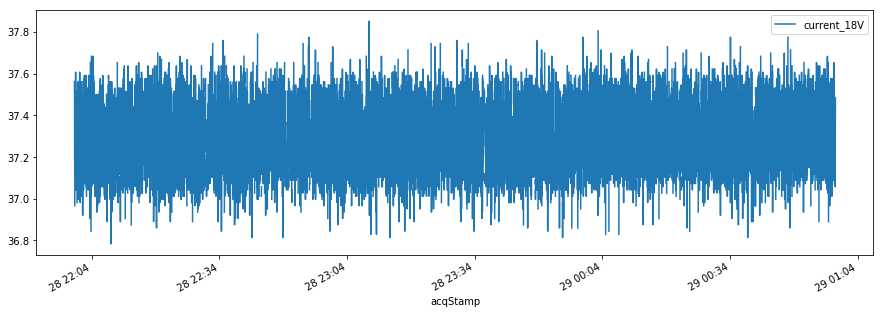

In [4]:
p_df = df1.select('acqStamp','current_18V').toPandas()
p_df.sort_values(by='acqStamp').plot(pd.to_datetime(p_df['acqStamp'],unit='ns'),'current_18V',figsize=(15,5))

### Read TGM data

In [5]:
tgmQuery = DevicePropertyQueryBuilder().system("CMW").device("CPS.TGM").property("FULL-TELEGRAM.STRC") \
    .start_time("2018-04-29 00:00:00.000").end_time("2018-05-01 00:00:00.000").build()
tgmData = spark.read.options(**tgmQuery.get_map()).format("cern.accsoft.nxcals.data.access.api").load()

In [6]:
tgmData.toPandas()[:2]

,BATCH,BEAMID,BPNM,COMLN,CYCLE,CYTAG,DEST,DEST2,DURN,FREE14,...,USER,__record_timestamp__,__record_version__,acqStamp,class,cyclestamp,device,nxcals_entity_id,property,selector
0,0,56006,22,None,19,None,EAST_N,NTOF,2,None,...,EAST2,1524960105100000000,0,1524960105000000000,CPS.TGM,1524960105100000000,CPS.TGM,46955,FULL-TELEGRAM.STRC,CPS.USER.ALL
1,0,52324,5,None,5,None,TT2_FTA,NONE,2,None,...,AD,1524960689500000000,0,1524960689400000000,CPS.TGM,1524960689500000000,CPS.TGM,46955,FULL-TELEGRAM.STRC,CPS.USER.ALL


In [7]:
tgmData.groupBy("USER").count().show()

+-------+-----+
|   USER|count|
+-------+-----+
|  EAST1|  663|
|     AD|   90|
|   LHC4|   77|
|   ZERO| 2437|
|  EAST2|  754|
|    TOF| 1793|
|    MD5|   56|
|SFTPRO2| 1510|
+-------+-----+



In [8]:
tgm_df_dump = tgmData.select("cyclestamp", "USER","DEST").where("DEST = 'PS_DUMP' AND USER != 'ZERO'")
tgm_df_dump.show()

+-------------------+----+-------+
|         cyclestamp|USER|   DEST|
+-------------------+----+-------+
|1524960868300000000| TOF|PS_DUMP|
|1524960292300000000| TOF|PS_DUMP|
|1524960925900000000| TOF|PS_DUMP|
|1524960407500000000| TOF|PS_DUMP|
|1524961012300000000| TOF|PS_DUMP|
|1524960004300000000| TOF|PS_DUMP|
|1524960609100000000| TOF|PS_DUMP|
|1524960724300000000| TOF|PS_DUMP|
|1524960263500000000| TOF|PS_DUMP|
|1524960321100000000| TOF|PS_DUMP|
|1524960522700000000| TOF|PS_DUMP|
|1524960033100000000| TOF|PS_DUMP|
|1524960753100000000| TOF|PS_DUMP|
|1524960695500000000| TOF|PS_DUMP|
|1524960839500000000| TOF|PS_DUMP|
|1524960378700000000| TOF|PS_DUMP|
|1524960954700000000| TOF|PS_DUMP|
|1524960061900000000| TOF|PS_DUMP|
|1524960090700000000| TOF|PS_DUMP|
|1524960205900000000| TOF|PS_DUMP|
+-------------------+----+-------+
only showing top 20 rows



### Read FTN data

In [9]:
dataQuery = DevicePropertyQueryBuilder().system("CMW").device("FTN.QFO415S").property("Acquisition") \
    .start_time("2018-04-20 00:00:00.000").end_time("2018-04-21 00:00:00.000").build()
data = spark.read.options(**dataQuery.get_map()).format("cern.accsoft.nxcals.data.access.api").load()

In [10]:
data.toPandas()[:2]

,__record_timestamp__,__record_version__,acqStamp,acq_2,class,current,current_max,current_min,current_status,current_tola,current_tolr,current_unit,cyclestamp,device,nxcals_entity_id,property,selector
0,1524250417900000000,0,1524250418000238525,NaN,PowM1553,114.983322,NaN,NaN,None,NaN,NaN,None,1524250417900000000,FTN.QFO415S,54169,Acquisition,CPS.USER.ZERO
1,1524250462300000000,0,1524250462400238525,NaN,PowM1553,114.985718,NaN,NaN,None,NaN,NaN,None,1524250462300000000,FTN.QFO415S,54169,Acquisition,CPS.USER.TOF


In [11]:
data.describe("current").show()

+-------+--------------------+
|summary|             current|
+-------+--------------------+
|  count|                6979|
|   mean|  114.98360330407027|
| stddev|0.001061515199792415|
|    min|          114.978775|
|    max|          114.989716|
+-------+--------------------+



### Showing current sum for all *EAST* users:

In [12]:
from pyspark.sql.functions import sum
data.where("selector like '%EAST%'").select(sum(data.current)).show()

+------------------+
|      sum(current)|
+------------------+
|196391.96104431152|
+------------------+



### Showing current sum for destination *TOF* using join:

In [13]:
tgmFiltered = tgmData.where("DEST like '%TOF%'")
tgmFiltered.count()
tgmFiltered.join(data, "cyclestamp").agg(sum(data.current)).show()

+------------+
|sum(current)|
+------------+
|        null|
+------------+

